In [16]:
import pandas as pd
import numpy as np
import requests
from census import Census
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set Seaborn style
sns.set_style("whitegrid")

# Ensure the output directory exists
os.makedirs('plots/', exist_ok=True)

# Step 1: Fetch 2019 311 Service Requests Data
# --------------------------------------------
# API endpoint
url = "https://data.cityofnewyork.us/resource/erm2-nwe9.json"



# Define query parameters to fetch 2019 data
params = {
    "$where": "created_date >= '2019-01-01T00:00:00' AND created_date <= '2019-12-31T23:59:59'",
    "$limit": 10000,  # Maximum records per request
    "$offset": 0,     # Pagination offset

    "$select": "created_date,complaint_type,incident_zip"  # Select required fields
}

# Fetch data with pagination
results = []
while True:
    response = requests.get(url, params=params)
    if response.status_code != 200 or not response.json():  # Break if request fails or no more data
        break
    data = response.json()
    results.extend(data)
    params["$offset"] += params["$limit"]
    print(f"Fetched {params['$offset']} records")

# Convert to Pandas DataFrame
df_311 = pd.DataFrame(results)

Fetched 10000 records
Fetched 20000 records
Fetched 30000 records
Fetched 40000 records
Fetched 50000 records
Fetched 60000 records
Fetched 70000 records
Fetched 80000 records
Fetched 90000 records
Fetched 100000 records
Fetched 110000 records
Fetched 120000 records
Fetched 130000 records
Fetched 140000 records
Fetched 150000 records
Fetched 160000 records
Fetched 170000 records
Fetched 180000 records
Fetched 190000 records
Fetched 200000 records
Fetched 210000 records
Fetched 220000 records
Fetched 230000 records
Fetched 240000 records
Fetched 250000 records
Fetched 260000 records
Fetched 270000 records
Fetched 280000 records
Fetched 290000 records
Fetched 300000 records
Fetched 310000 records
Fetched 320000 records
Fetched 330000 records
Fetched 340000 records
Fetched 350000 records
Fetched 360000 records
Fetched 370000 records
Fetched 380000 records
Fetched 390000 records
Fetched 400000 records
Fetched 410000 records
Fetched 420000 records
Fetched 430000 records
Fetched 440000 recor

In [18]:
# Step 2: Clean and Preprocess 311 Data
# -------------------------------------
df_311['created_date'] = pd.to_datetime(df_311['created_date'])
df_311 = df_311.dropna(subset=['incident_zip'])
complaints_by_zip = df_311.groupby('incident_zip').size().reset_index(name='complaint_count')

# Step 3: Fetch 2019 NYC Census Data
# ----------------------------------
# Initialize Census client with provided API key
c = Census("fd4d0a01d2649b01978b26f5981e56850d91a524")

# Attempt to fetch Census data with additional demographic variables
try:
    census_data = c.acs5.state_zipcode(
        ('NAME', 'B01003_001E', 'B19013_001E', 'B01002_001E', 'B03002_003E', 'B03002_004E', 'B03002_012E'),
        state_fips="36", zcta="*"
    )
    df_census = pd.DataFrame(census_data)
except Exception as e:
    print(f"Census API Error: {e}")
    print("Falling back to manual Census data loading or skipping Census analysis.")
    df_census = pd.DataFrame()

# Check if Census data was successfully fetched
if not df_census.empty:
    # Rename columns with demographic variables
    df_census = df_census.rename(columns={
        'NAME': 'zip_code',
        'B01003_001E': 'population',
        'B19013_001E': 'median_income',
        'B01002_001E': 'median_age',
        'B03002_003E': 'white_population',
        'B03002_004E': 'black_population',
        'B03002_012E': 'hispanic_population'
    })

    # Convert data types and handle missing values
    df_census['zip_code'] = df_census['zip_code'].astype(str)
    df_census = df_census.dropna(subset=['population', 'median_income', 'median_age', 'white_population', 'black_population', 'hispanic_population'])
    for col in ['population', 'median_income', 'median_age', 'white_population', 'black_population', 'hispanic_population']:
        df_census[col] = df_census[col].astype(float)
    df_census = df_census[df_census['population'] > 0]

    # Calculate demographic fractions
    df_census['frac_white'] = df_census['white_population'] / df_census['population']
    df_census['frac_black'] = df_census['black_population'] / df_census['population']
    df_census['frac_hispanic'] = df_census['hispanic_population'] / df_census['population']

    # Step 4: Merge 311 Data with Census Data
    # ---------------------------------------
    df_merged = pd.merge(complaints_by_zip, df_census, left_on='incident_zip', right_on='zip_code', how='inner')
    df_merged = df_merged.drop(columns=['zip_code'])

    # Step 5: Analyze Socioeconomic and Demographic Impact
    # --------------------------------------------------
    df_merged['complaints_per_capita'] = df_merged['complaint_count'] / df_merged['population']

    # Correlation analysis for multiple variables
    demo_vars = ['median_income', 'median_age', 'frac_white', 'frac_black', 'frac_hispanic']
    for var in demo_vars:
        corr = df_merged[var].corr(df_merged['complaints_per_capita'])
        print(f"Correlation between {var} and complaints per capita: {corr:.3f}")

    # Linear regression for median income
    X = df_merged[['median_income']]
    y = df_merged['complaints_per_capita']
    model = LinearRegression()
    model.fit(X, y)
    print(f"Regression coefficient for median income: {model.coef_[0]:.6f}")
    print(f"Intercept: {model.intercept_:.6f}")
    print(f"R-squared for median income: {model.score(X, y):.3f}")



Census API Error: ' <html style="font-size: 14px;">     <head>         <title>Invalid Key</title>         <link rel="icon" type="image/x-icon" href="favicon.ico">         <link rel="stylesheet" type="text/css" href="assets/styles.css">         <script type="text/javascript" src="assets/jquery-1.4.4.min.js"></script>         <script type="text/javascript">             $(document).ready(function() {                 $(".menu-activator").click(function() {                     $(".gov-menu").toggle()                     $(".chevron").toggleClass(\'rotate\')                 })                             })         </script>     </head>     <body>         <header>             <div data-v-8adc6fed="" data-v-2f72e816="" class="gov-banner noprint">                 <div data-v-8adc6fed="" class="aqua-layout horizontal align-start justify-start banner-header">                                          <span data-v-8adc6fed="">                         <div data-v-8adc6fed="" class="aqua-layout hori

In [23]:

# Step 6: Extended Visualization with Demographic Data
    # ----------------------------------------------------
    # Plot 1: Median Income vs Complaints Per Capita
    plt.figure(figsize=(10, 6))
    sns.regplot(x='median_income', y='complaints_per_capita', data=df_merged)
    plt.title('Median Household Income vs Complaints Per Capita')
    plt.xlabel('Median Household Income (USD)')
    plt.ylabel('Complaints Per Capita')
    plt.savefig('plots/median_income_vs_complaints_per_capita.png')
    plt.show()

    # Plot 2: Population vs Complaint Count
    plt.figure(figsize=(10, 6))
    sns.regplot(x='population', y='complaint_count', data=df_merged)
    plt.title('Population vs Complaint Count')
    plt.xlabel('Population')
    plt.ylabel('Complaint Count')
    plt.xscale('log')
    plt.yscale('log')
    plt.savefig('plots/population_vs_complaint_count.png')
    plt.show()

    # Plot 3: Median Age vs Complaints Per Capita
    plt.figure(figsize=(10, 6))
    sns.regplot(x='median_age', y='complaints_per_capita', data=df_merged)
    plt.title('Median Age vs Complaints Per Capita')
    plt.xlabel('Median Age')
    plt.ylabel('Complaints Per Capita')
    plt.savefig('plots/median_age_vs_complaints_per_capita.png')
    plt.show()

    # Plot 4: Fraction White vs Complaints Per Capita
    plt.figure(figsize=(10, 6))
    sns.regplot(x='frac_white', y='complaints_per_capita', data=df_merged)
    plt.title('Fraction White Population vs Complaints Per Capita')
    plt.xlabel('Fraction White')
    plt.ylabel('Complaints Per Capita')
    plt.savefig('plots/frac_white_vs_complaints_per_capita.png')
    plt.show()

    # Plot 5: Fraction Black vs Complaints Per Capita
    plt.figure(figsize=(10, 6))
    sns.regplot(x='frac_black', y='complaints_per_capita', data=df_merged)
    plt.title('Fraction Black Population vs Complaints Per Capita')
    plt.xlabel('Fraction Black')
    plt.ylabel('Complaints Per Capita')
    plt.savefig('plots/frac_black_vs_complaints_per_capita.png')
    plt.show()

    # Plot 6: Fraction Hispanic vs Complaints Per Capita
    plt.figure(figsize=(10, 6))
    sns.regplot(x='frac_hispanic', y='complaints_per_capita', data=df_merged)
    plt.title('Fraction Hispanic Population vs Complaints Per Capita')
    plt.xlabel('Fraction Hispanic')
    plt.ylabel('Complaints Per Capita')
    plt.savefig('plots/frac_hispanic_vs_complaints_per_capita.png')
    plt.show()

    # Plot 7: Boxplot of Complaints Per Capita by Income Quartile
    df_merged['income_quartile'] = pd.qcut(df_merged['median_income'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='income_quartile', y='complaints_per_capita', data=df_merged)
    plt.title('Complaints Per Capita by Income Quartile')
    plt.xlabel('Income Quartile')
    plt.ylabel('Complaints Per Capita')
    plt.savefig('plots/complaints_by_income_quartile.png')
    plt.show()

    # Save merged data
    # df_merged.to_csv('merged_311_census_2019.csv', index=False)

IndentationError: unexpected indent (<ipython-input-23-0106090c472e>, line 4)

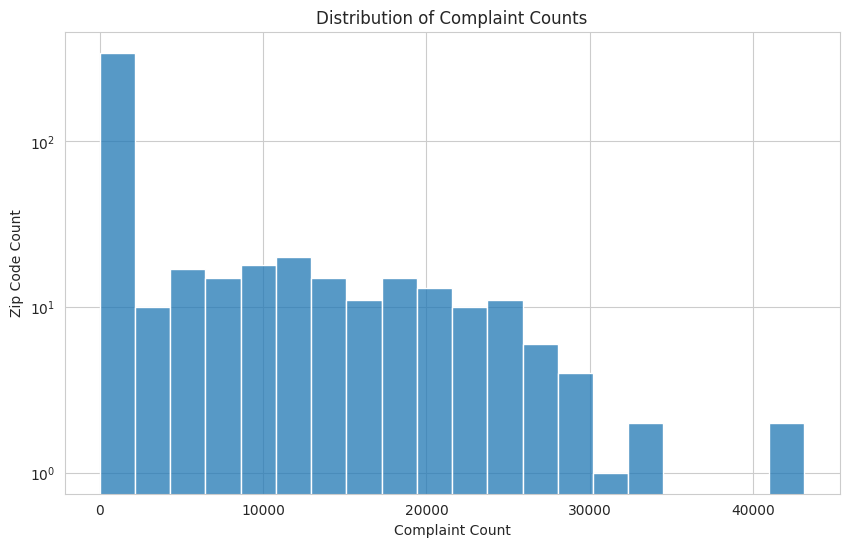

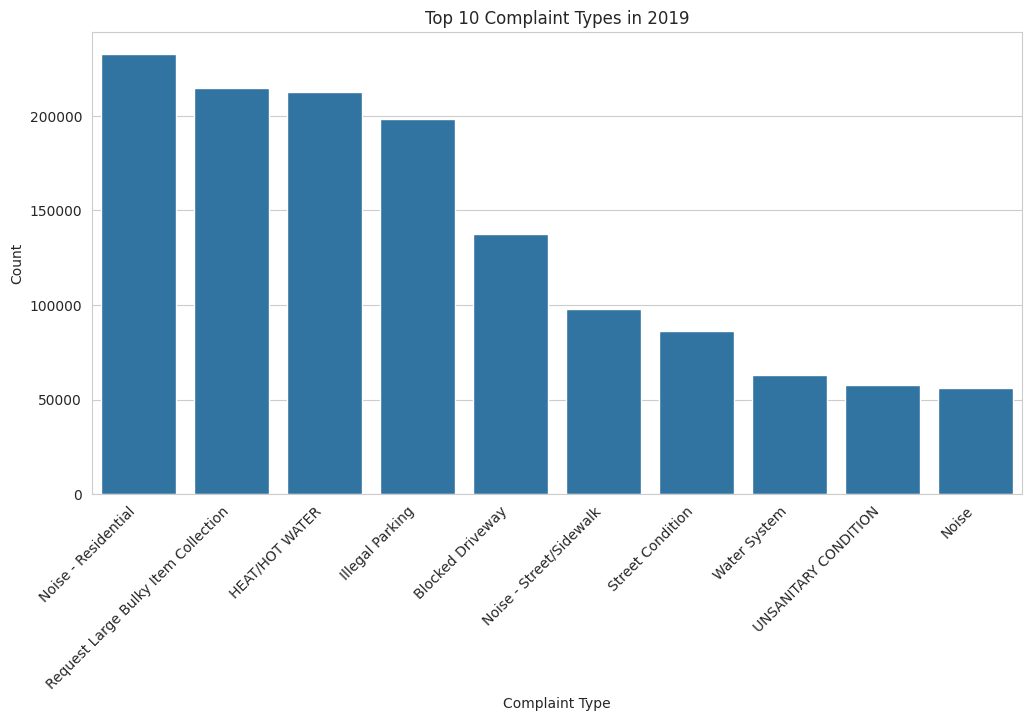

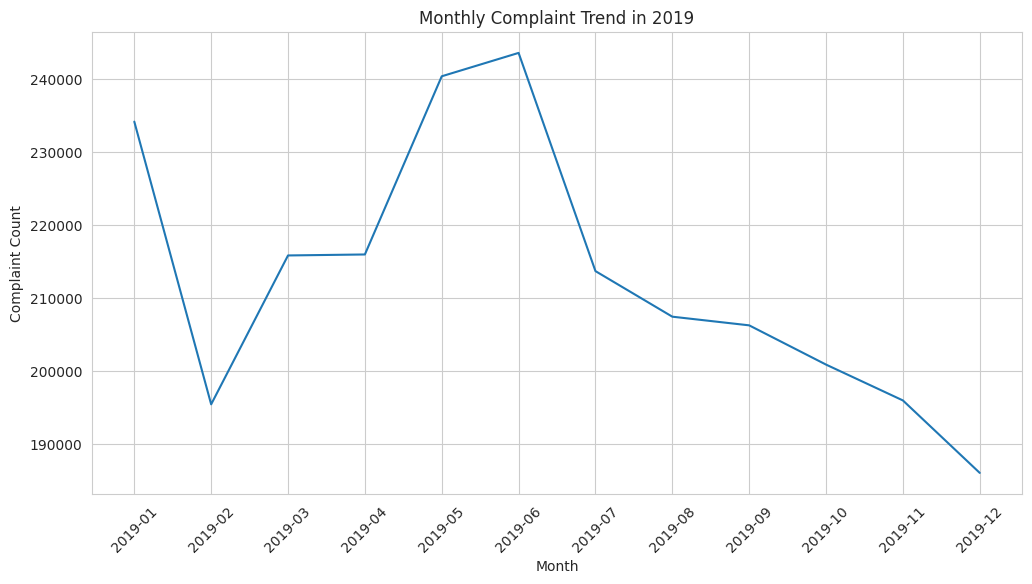

311 data saved to '311_data_2019.csv'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:


# Step 7: Visualize 311 Data Regardless of Census Availability
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.histplot(complaints_by_zip['complaint_count'], bins=20)
plt.title('Distribution of Complaint Counts')
plt.xlabel('Complaint Count')
plt.ylabel('Zip Code Count')
plt.yscale('log')
plt.savefig('plots/complaint_count_histogram.png')
plt.show()

complaint_types = df_311['complaint_type'].value_counts().head(10).reset_index()
complaint_types.columns = ['complaint_type', 'count']
plt.figure(figsize=(12, 6))
sns.barplot(x='complaint_type', y='count', data=complaint_types)
plt.title('Top 10 Complaint Types in 2019')
plt.xlabel('Complaint Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.savefig('plots/top_complaint_types.png')
plt.show()

# Check if 'borough' column exists before plotting
if 'borough' in df_311.columns:
    borough_complaints = df_311['borough'].value_counts().reset_index()
    borough_complaints.columns = ['borough', 'count']
    plt.figure(figsize=(10, 6))
    sns.barplot(x='borough', y='count', data=borough_complaints)
    plt.title('Complaints by Borough in 2019')
    plt.xlabel('Borough')
    plt.ylabel('Complaint Count')
    plt.savefig('plots/complaints_by_borough.png')
    plt.show()
else:
    print("Warning: 'borough' column not found in df_311. Skipping borough plot.")

# Additional 311-specific Plot: Complaint Trend Over Time
# Convert Period to string to avoid TypeError
df_311['month'] = df_311['created_date'].dt.to_period('M').astype(str)
monthly_complaints = df_311.groupby('month').size().reset_index(name='count')
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='count', data=monthly_complaints)
plt.title('Monthly Complaint Trend in 2019')
plt.xlabel('Month')
plt.ylabel('Complaint Count')
plt.xticks(rotation=45)
plt.savefig('plots/monthly_complaint_trend.png')
plt.show()

# Save 311 data
df_311.to_csv('311_data_2019.csv', index=False)
print("311 data saved to '311_data_2019.csv'.")

# Enable downloading files from Colab
from google.colab import files
files.download('311_data_2019.csv')
if not df_census.empty:
    files.download('merged_311_census_2019.csv')